In [1]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import keras
import h5py

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d daavoo/3d-mnist

 94% 145M/154M [00:01<00:00, 88.5MB/s]
100% 154M/154M [00:01<00:00, 86.3MB/s]


In [7]:
!ls

3d-mnist.zip  kaggle.json  sample_data


In [8]:
!unzip "3d-mnist.zip"

Archive:  3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


In [9]:
!ls

3d-mnist.zip		 plot3D.py	       train_point_clouds.h5
full_dataset_vectors.h5  sample_data	       voxelgrid.py
kaggle.json		 test_point_clouds.h5


In [0]:
with h5py.File('full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [11]:
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)

print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [0]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
  
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
    
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [14]:
xtrain.shape, y_train.shape, xtest.shape, y_test.shape

((10000, 16, 16, 16, 3), (10000, 10), (2000, 16, 16, 16, 3), (2000, 10))

In [17]:
img_3d = xtrain[0][:,:,:,1]
img_3d.shape

(16, 16, 16)

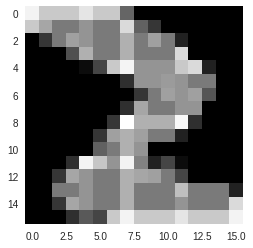

In [16]:
plt.grid(False)
plt.imshow(img_3d[:,:,10])

In [19]:
x_train_gray = []
x_test_gray = []

for img in xtrain:
  x_train_gray.append(img[:,:,:,1])
  
for img in xtest:
  x_test_gray.append(img[:,:,:,1])
  

x_train_gray = np.array(x_train_gray)
x_test_gray = np.array(x_test_gray)

x_train_gray.shape, x_test_gray.shape

((10000, 16, 16, 16), (2000, 16, 16, 16))

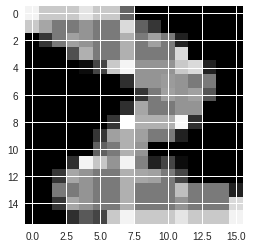

In [21]:
plt.imshow(x_train_gray[0][:,:,10])

In [22]:
x_train_gray.shape, y_train.shape, x_test_gray.shape, y_test.shape

((10000, 16, 16, 16), (10000, 10), (2000, 16, 16, 16), (2000, 10))

Expand training set dimensions to match with input shape of netwwork

In [33]:
x_train_5d = np.expand_dims(x_train_gray, axis=4)
x_test_5d = np.expand_dims(x_test_gray, axis=4)


x_train_5d.shape, x_test_5d.shape

((10000, 16, 16, 16, 1), (2000, 16, 16, 16, 1))

https://medium.com/shashwats-blog/3d-mnist-b922a3d07334

https://gist.github.com/imshashwataggarwal/89e78280267bfd6bf195707ff9b47d93#file-3d_cnn-py

In [34]:
def m1():
  
  '''Architecture for 3D MNIST with shape 4D(w,h,b and color channel of 3)'''
  
  
  ## input layer
  input_layer = Input((16, 16, 16, 3))

  ## convolutional layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

  ## add max pooling to obtain the most imformatic features
  pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
  conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
  pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

  ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
  pooling_layer2 = BatchNormalization()(pooling_layer2)
  flatten_layer = Flatten()(pooling_layer2)

  ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
  ## add dropouts to avoid overfitting / perform regularization
  dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=10, activation='softmax')(dense_layer2)

  ## define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # optimizers.SGD(lr=1e-4, momentum=0.9)
  model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
  return model




def m2():
  
  '''................................................'''
  
  ## input layer
  input_layer = Input((16, 16, 16, 1)) # 1 is just dummy dimension good for nothing 

  ## convolutional layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

  ## add max pooling to obtain the most imformatic features
  pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
  conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
  pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

  ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
  pooling_layer2 = BatchNormalization()(pooling_layer2)
  flatten_layer = Flatten()(pooling_layer2)

  ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
  ## add dropouts to avoid overfitting / perform regularization
  dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=10, activation='softmax')(dense_layer2)

  ## define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # optimizers.SGD(lr=1e-4, momentum=0.9)
  model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
  return model

model = None
model = m2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 16, 16, 16, 1)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 14, 14, 14, 8)     224       
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 1, 1, 1, 64)       0         
__________

In [35]:
x_train_5d.shape, y_train.shape

((10000, 16, 16, 16, 1), (10000, 10))

In [36]:
model.fit(x=x_train_5d, y=y_train, batch_size=128, epochs=100, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 9s 971us/step - loss: 2.2509 - acc: 0.2099 - val_loss: 2.1808 - val_acc: 0.1910
Epoch 2/100
9000/9000 [==============================] - 3s 295us/step - loss: 1.8179 - acc: 0.3854 - val_loss: 1.6921 - val_acc: 0.4240
Epoch 3/100
9000/9000 [==============================] - 3s 296us/step - loss: 1.4220 - acc: 0.5228 - val_loss: 1.7318 - val_acc: 0.4390
Epoch 4/100
9000/9000 [==============================] - 3s 297us/step - loss: 1.2536 - acc: 0.5712 - val_loss: 1.9379 - val_acc: 0.3870
Epoch 5/100
9000/9000 [==============================] - 3s 295us/step - loss: 1.1575 - acc: 0.5949 - val_loss: 1.4590 - val_acc: 0.4910
Epoch 6/100
9000/9000 [==============================] - 3s 296us/step - loss: 1.0815 - acc: 0.6273 - val_loss: 1.1776 - val_acc: 0.5980
Epoch 7/100
9000/9000 [==============================] - 3s 297us/step - loss: 1.0

In [0]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    #plt.savefig('raja_exp1_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    #plt.savefig('raja_exp1_acc.jpg', dpi=300)
    plt.show()

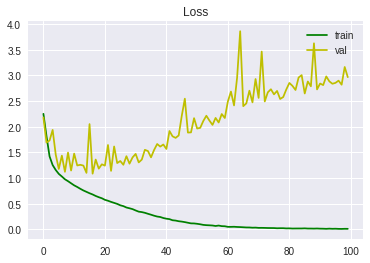

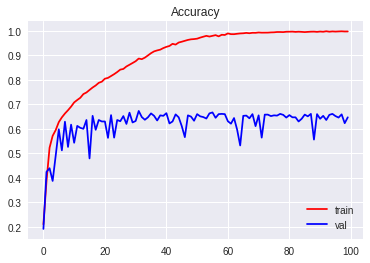

Done!


In [38]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [0]:
y_pred = None
pred_labels = None
accuracy = None

In [0]:
# make preds
y_pred = model.predict(x_test_5d)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

In [0]:
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)

In [44]:
# eval on test set
accuracy = np.mean((y_test==pred_labels))
accuracy

0.644

In [46]:
def m3():
  
  '''playing function'''
  
  ## input layer
  input_layer = Input((512, 512, 144, 1)) # 1 is just dummy dimension good for nothing 

  ## convolutional layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

  ## add max pooling to obtain the most imformatic features
  pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
  conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
  pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

  ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
  pooling_layer2 = BatchNormalization()(pooling_layer2)
  flatten_layer = Flatten()(pooling_layer2)

  ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
  ## add dropouts to avoid overfitting / perform regularization
  dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=2, activation='softmax')(dense_layer2)

  ## define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # optimizers.SGD(lr=1e-4, momentum=0.9)
  model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
  return model

model = None
model = m3()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 512, 144, 1)  0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 510, 510, 142, 8)  224       
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 508, 508, 140, 16) 3472      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 254, 254, 70, 16)  0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 252, 252, 68, 32)  13856     
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 250, 250, 66, 64)  55360     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 125, 125, 33, 64)  0         
__________